# 1. Détermination des propriétés du sous-marins

Hypothèses émises :

$\quad$ 1) Les forces liées au lift peuvent être négligées étant données des vitesses d'opération relativement faibles

$\quad$ 2) Le sous-marin est approximativement symétrique selon les 3 axes
 
$\quad$ 3) Le sous-marin reste horizontal étant donné que le centre de flotaison est bien aligné juste au dessus du centre de gravité

$\quad$ 4) Le roll et le pitch sont négligée ...

$\quad$ 5) Le centre de gravité est placé aux coordonnées 
$
r_{G} =
\begin{bmatrix}
0 & 0 & 0
\end{bmatrix}^T
$

$\quad$ 6) La matrice de positionnement des moteurs et ballastes peut être négligée, Ainsi, seulement une force selon chaque axe sera obtenu pour la simulation.  

$\quad$ 7) Les mouvements selon un degré de liberté n'affectent pas les autres degrés de liberté, ainsi, les mouvements selon chaque axes sont découplés. Ce model est valide seulement si nous négligeons les courrant marins.
De plus, cela permet de négliger la force centrifuge et la force de coriolis.


Paramètres du sous-marin : 

$\quad$$m$ [kg] est la masse du sous-marin\
$\quad$$g$ [m/s²] est la constante gravitationnelle \
$\quad$$p$ [kg/m³]est la densité du fluide \
$\quad$$∇$ [L] est le volume de fluide déplacé par le sous-marin 

$\quad$$
r_{G} =
\begin{bmatrix}
x_g & y_g & z_g 
\end{bmatrix}^T
$
est le centre de gravité du sous-marin \
$\quad$$
r_{B} =
\begin{bmatrix}
x_b & y_b & z_b 
\end{bmatrix}^T
$
est le centre de flotaison du sous-marin 

$\quad$$l_1$ [m] est la distance du moteur 1 jusqu'au centre de masse \
$\quad$$l_2$ [m] est la distance du moteur 2 jusqu'au centre de masse \
$\quad$$l_3$ [m] est la distance de la ballaste 1 jusqu'au centre de masse \
$\quad$$l_4$ [m] est la distance de la ballaste 2 jusqu'au centre de masse 

$\quad$$I_{xx}$ [kgm²] est l'inertie selon l'axe x\
$\quad$$I_{yy}$ [kgm²] est l'inertie selon l'axe y\
$\quad$$I_{zz}$ [kgm²] est l'inertie selon l'axe z

$\quad$$X_{u}$ [Ns/m] est le paramètre de drag linéaire selon le surge\
$\quad$$Y_{v}$ [Ns/m] est le paramètre de drag linéaire selon le sway\
$\quad$$Z_{w}$ [Ns/m] est le paramètre de drag linéaire selon le heave\
$\quad$$K_{p}$ [Ns/m] est le paramètre de drag linéaire selon le roll\
$\quad$$M_{q}$ [Ns/m] est le paramètre de drag linéaire selon le pitch\
$\quad$$N_{r}$ [Ns/m] est le paramètre de drag linéaire selon le yaw

$\quad$$X_{u|u|}$ [Ns²/m²] est le paramètre de drag quadratique selon le surge\
$\quad$$Y_{v|v|}$ [Ns²/m²] est le paramètre de drag quadratique selon le sway\
$\quad$$Z_{w|w|}$ [Ns²/m²] est le paramètre de drag quadratique selon le heave\
$\quad$$K_{p|p|}$ [Ns²/m²] est le paramètre de drag quadratique selon le roll\
$\quad$$M_{q|q|}$ [Ns²/m²] est le paramètre de drag quadratique selon le pitch\
$\quad$$N_{r|r|}$ [Ns²/m²] est le paramètre de drag quadratique selon le yaw

In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint, RK45
from numpy.linalg import inv
import numpy as np
import math

"""
==========================================================
Declaration des paramètres physiques
==========================================================
"""

m = 502  # [kg] est la masse du sous-marin
g = 9.81 # [m/s²] est la constante gravitationnelle 
p = 998  # [kg/m³]est la densité du fluide 
V = 531  # [L] est le volume de fluide déplacé par le sous-marin 

rG = [0,0,0]   # est le centre de gravité du sous-marin 
rB = [0,0,0.1] # est le centre de flotaison du sous-marin 

l1 = 0.1 # [m] est la distance du moteur 1 jusqu'au centre de masse 
l2 = 0.1 # [m] est la distance du moteur 2 jusqu'au centre de masse 
l3 = 0.1 # [m] est la distance de la ballaste 1 jusqu'au centre de masse 
l4 = 0.1 # [m] est la distance de la ballaste 2 jusqu'au centre de masse 

Ixx = 809 # [kgm²] est l'inertie selon l'axe x\
Iyy = 818 # [kgm²] est l'inertie selon l'axe y\
Izz = 264  # [kgm²] est l'inertie selon l'axe z\

Xu = 120 # [Ns/m] est le paramètre de drag linéaire selon le surge
Yv = 90  # [Ns/m] est le paramètre de drag linéaire selon le sway
Zw = 150 # [Ns/m] est le paramètre de drag linéaire selon le heave
Kp = 0   # [Ns/m] est le paramètre de drag linéaire selon le roll
Mq = 0   # [Ns/m] est le paramètre de drag linéaire selon le pitch
Nr = 18  # [Ns/m] est le paramètre de drag linéaire selon le yaw

Xuu = 90  # [Ns²/m²] est le paramètre de drag quadratique selon le surge
Yvv = 90  # [Ns²/m²] est le paramètre de drag quadratique selon le sway
Zww = 120 # [Ns²/m²] est le paramètre de drag quadratique selon le heave
Kpp = 0   # [Ns²/m²] est le paramètre de drag quadratique selon le roll
Mqq = 0   # [Ns²/m²] est le paramètre de drag quadratique selon le pitch
Nrr = 15  # [Ns²/m²] est le paramètre de drag quadratique selon le yaw

Params = [m,g,p,V,rG,rB,l1,l2,l3,l4,Ixx,Iyy,Izz,Xu,Yv,Zw,Kp,Mq,Nr,Xuu,Yvv,Zww,Kpp,Mqq,Nrr]

# Pour usage simple 
# Params = [m, g, p, V, rG, rB, l1, l2, l3, l4, Ixx, Iyy, Izz, Xu, Yv, Zw, Kp, Mq, Nr, Xuu, Yvv, Zww, Kpp, Mqq, Nrr]
#           0  1  2  3   4   5   6   7   8   9   10   11  12   13  14  15  16  17  18   19   20   21   22   23   24

# 2. Modélisation dynamique sous-marin

$\quad$ Le but de ce script est de définir la dynamique de notre sous-marin dans le but de faire un asservissement complet et de valider le positionnement des moteurs et des ballastes. 


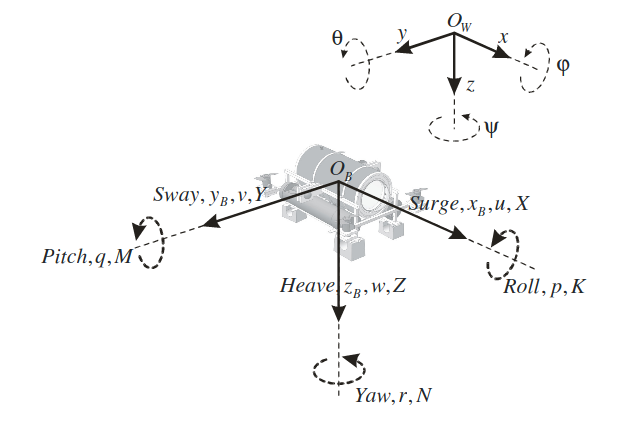


$\quad$ Deux types de références sont utilisées, soit une en référence au corps du sous-marins (B) et un autre référencé à l'environnement du sous-marin (W). Les degrées de liberté de chacun des plans de référence sont représentés sout la forme :

$$
χ = 
\begin{bmatrix}
surge & sway & heave & roll & pitch & yaw
\end{bmatrix}^T
$$

$$
=
\begin{bmatrix}
x_B & y_B & z_B & φ_B & θ_B & ψ_B 
\end{bmatrix}^T
$$

et 

$$
η =
\begin{bmatrix}
x & y & z & φ & θ & ψ
\end{bmatrix}^T
$$

$\quad$

$\quad$ Ainsi les vecteurs de vitesse V et $\dot{η}$ pour les plan de référence B et W respectivement sont : 

$$
V =
\begin{bmatrix}
\dot{x_B} & \dot{y_B} & \dot{z_B} & \dot{φ_B} & \dot{θ_B} & \dot{ψ_B}   
\end{bmatrix}^T
$$

$$
=
\begin{bmatrix}
u & v & w & p & q & r 
\end{bmatrix}^T
$$

et

$$
\dot{η} =
\begin{bmatrix}
\dot{x} & \dot{y} & \dot{z} & \dot{φ} & \dot{θ} & \dot{ψ}
\end{bmatrix}^T
$$

Avec le vecteur de force/torque représenté par le vecteur τ : 

$$
τ =
\begin{bmatrix}
τ_u & τ_v & τ_w & τ_φ & τ_φ & τ_ψ 
\end{bmatrix}^T
$$




# 3. Transformation des vecteurs d'état

$\quad$ La transformation des vecteurs de position, de vitesse et d'accélération du plan B au plan W est représenté par la figure suivante : 



$\quad$ Par la suite, afin de lier les deux plans de référence, nous utilisons les angles d'Euler pour orienter les coordonnées du système par rapport à l'autre. Ainsi, la matrice de rotation représentant l'orientation du plan B par rapport au plan W est donné par : 


$$ R^{BW} (φ, θ, ψ) = R_z(ψ)R_y(θ)R_x(φ)$$

# 3.1 Transformation du vecteur de position 

$\quad$ La position du sous-marin peut être décrite selon le plan B et le plan W sans transformation du vecteur de position. 

$\quad$ L'origine du plan B et W sont les mêmes dans le cas du surge, sway et le heave et la position est toujours décrite relative à la position initiale. 

$\quad$ Par contre, la position du plan B et W selon le roll, pith et le yaw peuvent être différent. L'orientation de W est selon le champ magnétique terrestre tandis que l'orientation de B est selon l'orientation du corps du sous-marin.

$\quad$ Par exemple, en se fiant à la figure ci-haut, au point A, l'orientation de B et W sont les même, soit $\vec{e^0}$. Par contre, si l'on se fie au point B, suite à l'application du vecteur $\vec{r^t}$, l'orientation selon le plan b devient $\vec{e^3}$ et l'orientation selon W devient $\vec{e^1}$, qui agit selon la même orientation que $\vec{e^0}$, soit l'orientation du champs magnétique de la terre.


# 3.2 Transformation du vecteur de vitesse

$\quad$ Le vecteur de vitesse est composé de vitesses linéaires et de vitesses angulaires. Ainsi, le vecteur de vitesse peut être transormé du plan B au plan W selon : 


$$ \dot{η} = J(η)ν $$ 

Où les matrices $\dot{η}$, v et J(η) sont représentées par : 


$$
\dot{η} =
\begin{bmatrix}
υ_W & ω_W
\end{bmatrix}^T
$$

$$
v =
\begin{bmatrix}
υ_B & ω_B
\end{bmatrix}^T
$$

$$
J(η) =
\begin{bmatrix}
J_1 (υ_W) & 0 \\
0 & J_2 (ω_W)
\end{bmatrix}
$$


avec : 

$v$ [m/s]est la vitesse selon le plan B \
$\dot{η}$  [m/s] est la vitesse selon le plan W \
$υ_B$  [m/s] est la vitesse linéaire selon le plan B \
$ω_B$  [rad/s]est la vitesse angulaire selon le plan B \
$υ_W$ [m/s] est la vitesse linéaire selon le plan W \
$ω_W$  [rad/s]est la vitesse angulaire selon le plan W \
$J(η)$ est la matrix de transformation 

Ainsi, les vitesses et accélérations linaires selon le plan W peut être définies selon : 


$$v_W = J_1 (v_W)v_B$$
$$J_1 (υ_W) = R^{BW}v_W$$

où : 

$$
J_1 (v_W) =
\begin{bmatrix}
cos(\theta)cos(ψ) & -cos(φ)sin(ψ)+sin(φ)sin(θ)cos(ψ) & sin(ψ)sin(φ)+cos(φ)sin(\theta)cos(ψ) \\
cos(\theta)cos(ψ) & cos(φ)sin(ψ)+sin(φ)sin(θ)cos(ψ) & -cos(φ)sin(ψ)+sin(φ)sin(θ)cos(ψ) \\
-sin(\theta) & sin(φ)cos(\theta) & cos(φ)cos(\theta)
\end{bmatrix}
$$

$\quad$

$\quad$ Puis, les vitesses et accélérations angulaires selon le plan B peut être définies selon : 

$$\vec{ω_W} = J_2(ω_W)\vec{ω_B}$$

où `

$$
J_2 (ω_W) =
\begin{bmatrix}
1 & sin(φ)T(\theta) & cos(φ)T(\theta)  \\
0 & cos(φ) & -sin(φ) \\
0 & sin(φ)/cos(\theta) & cos(φ)/cos(\theta)
\end{bmatrix}
$$

À noter que J_2 est non défini si ${\theta}$ +/- π/2, mais il le soumarin n'est pas supposé avoir un pitch près de +/- π/2 (90deg).

# 4. Modèle dynamique du sous-marin

$\quad$ Le model dynamique du sous-marin est défini selon la formule ci-dessous afin de bien formuler les lois de controle et une simulations adéquates. 

$$ M \dot{v} + D(v)v + g(η) = τ $$

où : 

$ M = M_{RB} + M_A $ est la matrice d'interie et de masse ajoutée \
$ D(v) = D_q(v) + D_1(v)$ est la matrice de drag linéaire et quadratique\
$g(n)$ est la matrice gravitationnelle et de flotabilité \
$τ$ est la matrice de force/torque des moteurs





# 4.1 Matrice de masse et d'inertie

$\quad$ La matrice de mass est d'inertie est composée de la masse d'un sous-marin et de la masse ajoutée, respectivement $M_{RB}$ et $M_A$ donc :

$$ M = M_{RB} + M_A $$

Ainsi, le terme de masse peut être défini selon : 

$$
M_{RB}\dot{v} =
\begin{bmatrix}
m\dot{v_B} + m\dot{w_B}r_G \\
I_B\dot{w_B} + mr_G \dot{v_B}\\
\end{bmatrix}
$$

où 

$m$ [kg] est la masse du sous-marin\
$I_B$ est la matrice d'inertie selon le plan de référence B donnée par : 

$$
I_{B} =
\begin{bmatrix}
I_{xx} & -I_{xy} & -I_{xz}\\
-I_{yx} & I_{yy} & -I_{yz}\\
-I_{zx} & -I_{zy} & I_{zz}\\
\end{bmatrix}
$$


$r_G$ est la matrice du centre de gravité selon le plan B donnée par : 

$$
r_{G} =
\begin{bmatrix}
x_G & y_G & z_G 
\end{bmatrix}^T
$$

$M_{RB}$ la matrice de masse est donnée par : 

$$
M_{RB} =
\begin{bmatrix}
m & 0 & 0 & 0 & mz_G & -my_G \\
0 & m & 0 & -mz_G & 0 & mx_G \\
0 & 0 & m & my_G & -mx_G & 0 \\
0 & -mz_G & my_G & I_{xx} & -I_{xy} & -I_{xz} \\
mz_G & 0 & -mx_G & -I_{yx} & I_{yy} & -I_{yz} \\
-my_G & mx_G & 0 & -I_{zx} & -I_{zy} & I_{zz} \\
\end{bmatrix}
$$

$\quad$ Étant donné que le sous-marin est symétrique selon le plan x-z et pratiquement similaire selon le plan x-y, il est donc possible d'assumer que tout est symetrique étant donné l'opération du véhicule à base vitesse. Donc si le sous-marin est symétrique selon tous les axes et que le centre de masse est placé à $r_G = [0, 0, 0]^T $, la matrice $M_{RB}$ peut être simplifiée selon : 

$$
M_{RB} =
\begin{bmatrix}
m & 0 & 0 & 0 & 0 & 0 \\
0 & m & 0 & 0 & 0 & 0 \\
0 & 0 & m & 0 & 0 & 0 \\
0 & 0 & 0 & I_{xx} & 0 & 0 \\
0 & 0 & 0 & 0 & I_{yy} & 0 \\
0 & 0 & 0 & 0 & 0 & I_{zz} \\
\end{bmatrix}
$$


Par la suite, la matrice de masse ajoutée hydrodynamique $M_A$ est représenté par : 

$$
M_{A} =
\begin{bmatrix}
X_{\dot{u}} & X_{\dot{v}} & X_{\dot{w}} & X_{\dot{p}} & X_{\dot{q}} & X_{\dot{r}} \\
Y_{\dot{u}} & Y_{\dot{v}} & Y_{\dot{w}} & Y_{\dot{p}} & Y_{\dot{q}} & Y_{\dot{r}} \\
Z_{\dot{u}} & Z_{\dot{v}} & Z_{\dot{w}} & Z_{\dot{p}} & Z_{\dot{q}} & Z_{\dot{r}} \\
K_{\dot{u}} & K_{\dot{v}} & K_{\dot{w}} & K_{\dot{p}} & K_{\dot{q}} & K_{\dot{r}} \\
M_{\dot{u}} & M_{\dot{v}} & M_{\dot{w}} & M_{\dot{p}} & M_{\dot{q}} & M_{\dot{r}} \\
N_{\dot{u}} & N_{\dot{v}} & N_{\dot{w}} & N_{\dot{p}} & N_{\dot{q}} & N_{\dot{r}} \\
\end{bmatrix}
$$

où 

$X_{\dot{u}}$ est $∂X/∂\dot{u}$. La même logique s'applique à tous les termes

$\quad$ Les termes nécessaires à la matrice de masse ajoutée est dépendante de la forme du sous-marin. Puis étant donné que le sous-marin est symétrique et que le centre de masse selon le plan B est situé au centre de gravité hydrodynamique, la matrice de masse $M_A$ peut être simplifé par : 

$$
M_{A} =
\begin{bmatrix}
X_{\dot{u}} & 0 & 0 & 0 & 0 & 0 \\
0 & Y_{\dot{v}} & 0 & 0 & 0 & 0 \\
0 & 0 & Z_{\dot{w}} & 0 & 0 & 0 \\
0 & 0 & 0 & K_{\dot{p}} & 0 & 0 \\
0 & 0 & 0 & 0 & M_{\dot{q}} & 0 \\
0 & 0 & 0 & 0 & 0 & N_{\dot{r}} \\
\end{bmatrix}
$$ 

À noter que $M_A$ > 0 et que $\dot{M_A}$ = 0. Les paramètre sont normallement situé entre 10% et 100% des paramètres respectifs de la matrice de masse. 



https://www.diva-portal.org/smash/get/diva2:1127931/FULLTEXT01.pdf


file:///home/ubuntu/Downloads/Martin-Renilson-Submarine-Hydrodynamics-Springer-International-Publishing-2018.pdf

In [2]:
# Params = [m, g, p, V, rG, rB, l1, l2, l3, l4, Ixx, Iyy, Izz, Xu, Yv, Zw, Kp, Mq, Nr, Xuu, Yvv, Zww, Kpp, Mqq, Nrr]
#           0  1  2  3   4   5   6   7   8   9   10   11  12   13  14  15  16  17  18   19   20   21   22   23   24

"""
Note : 
    
    - Ajouter added mass pour la partie intérieur remplie d'eau

"""

def M (Params): 
    
    # Initialiser la matrice M
    M = np.zeros((6,6))
    
    # Definir l'elipse équivalente pour approximer les coefficients de masse ajoutés
    L = 2.032 # Longueur du sous-marin en mètre
    d = ((6*Params[3])/(math.pi*Params[2]*L))
    
    # Déterminer les coefficients de masse ajoutée selon les axe x,y et z
    kx = -0.00047 * (L/d)**2 + 0.0134 * (L/d) - 0.059
    ky = -0.00088 * (L/d)**2 + 0.0245 * (L/d) + 0.805
    kz = ky 
    
    # Déterminer le moment d'inertie équivalent pour l'élipsoide
    Iyy = (math.pi*Params[2]/30)*(L*d)**4 * ((L/d)**2 + 1)
    
    # Déterminer la masse et le momment d'inertie non dimensionalisé
    m_nd = Params[3]/((1/2)*Params[2]*L**3)
    Iyy_nd = Iyy/((1/2)*Params[2]*L**5)
    Izz_nd = Iyy_nd
    
    # Déterminer les valeurs de masse ajoutée
    Xdu = 0
    Ydv = -ky * m_nd
    Zdw = -kz * m_nd
    Kdp = 0
    Mdq = -ky * Iyy_nd
    Ndr = -kz * Izz_nd
    
    # Définir la matrice de masse ajoutée
    MA = np.array([[Xdu,0,0,0,0,0],[0,Ydv,0,0,0,0],[0,0,Zdw,0,0,0],[0,0,0,Kdp,0,0],[0,0,0,0,Mdq,0],[0,0,0,0,0,Ndr]])
    
    # Définir la matrice de masse
    MRB = np.matrix([[Params[0],0,0,0,0,0],[0,Params[0],0,0,0,0],[0,0,Params[0],0,0,0],[0,0,0,Params[10],0,0],[0,0,0,0,Params[11],0],[0,0,0,0,0,Params[12]]])
                    
    M = MA + MRB

    return M



# 4.2 Matrice d'ammortissement

La matrice d'ammortissement comprend le drag et le lift affectant le sous-marin. Par contre, à base vitesse, le lift peut être négligé comparé aux forces de drag. Ainsi, les force de drags peuvent être séparées selon le drag linéaire et quadratique. La matrice de drag est représenté par : 

$$ D(v)= D_{q}(v) + D_l(v) $$

En assumant la symétrie du sous-marin, la matrice $D_l(v)$ est représenté par : 

$$
D_{l}(v) =
\begin{bmatrix}
X_{u} & 0 & 0 & 0 & 0 & 0 \\
0 & Y_{v} & 0 & 0 & 0 & 0 \\
0 & 0 & Z_{w} & 0 & 0 & 0 \\
0 & 0 & 0 & K_{p} & 0 & 0 \\
0 & 0 & 0 & 0 & M_{q} & 0 \\
0 & 0 & 0 & 0 & 0 & N_{r} \\
\end{bmatrix}
$$ 


Puis la force axiale quadratique de drag peut être représenté par : 

$$ X = - (0.5 ρ C_d A_f)u|u| = X_{u|u|}u|u| $$

où $X_{u|u|} = ∂X / ∂(u|u|) = -0.5 ρ C_d A_f $ 


Puis cela nous permet d'avoir la matrice de drag quadratique D_q(v) suivante : 

$$
D_{l}(v) =
\begin{bmatrix}
X_{u|u|}|u| & 0 & 0 & 0 & 0 & 0 \\
0 & Y_{v|v|}|v| & 0 & 0 & 0 & 0 \\
0 & 0 & Z_{w|w|}|w| & 0 & 0 & 0 \\
0 & 0 & 0 & K_{p|p|}|p| & 0 & 0 \\
0 & 0 & 0 & 0 & M_{q|q|}|q| & 0 \\
0 & 0 & 0 & 0 & 0 & N_{r|r|}|r| \\
\end{bmatrix}
$$ 

In [3]:
# Params = [m, g, p, V, rG, rB, l1, l2, l3, l4, Ixx, Iyy, Izz, Xu, Yv, Zw, Kp, Mq, Nr, Xuu, Yvv, Zww, Kpp, Mqq, Nrr]
#           0  1  2  3   4   5   6   7   8   9   10   11  12   13  14  15  16  17  18   19   20   21   22   23   24

def D (Params, Etat_vitesse): 
    
    # Initialiser la matrice M
    D = np.zeros((6,6))
   
    # Definition de la vitesse
    u = Etat_vitesse[0] # Vitesse selon le surge
    v = Etat_vitesse[1] # Vitesse selon le sway
    w = Etat_vitesse[2] # Vitesse selon le heave
    p = Etat_vitesse[3] # Vitesse selon le roll
    q = Etat_vitesse[4] # Vitesse selon le pitch
    r = Etat_vitesse[5] # Vitesse selon le yaw
    
    # Définir la matrice DL
    DL = np.array([[Params[13],0,0,0,0,0],[0,Params[14],0,0,0,0],[0,0,Params[15],0,0,0],[0,0,0,Params[16],0,0],[0,0,0,0,Params[17],0],[0,0,0,0,0,Params[18]]])
    
    # Définir la matrice DQ
    DQ = np.array([[Params[19]*abs(u),0,0,0,0,0],[0,Params[20]*abs(v),0,0,0,0],[0,0,Params[21]*abs(w),0,0,0],[0,0,0,Params[22]*abs(p),0,0],[0,0,0,0,Params[23]*abs(q),0],[0,0,0,0,0,Params[24]*abs(r)]])
                    
    D = DL + DQ
    
    return D


# 4.3 Matrice gravitationnelle et de flotabilité

La matrice gravitationnelle et de flotabilité $g(η)$ représenté par : 

$$
g(η) =
\begin{bmatrix}
f_B + f_G \\
r_b f_B + r_G f_g \\
\end{bmatrix}
$$ 

où le vecteur de force gravitationnel est représenté par : 

$$
f_G = R^{BW-1}(v_w)
\begin{bmatrix}
0 & 0 & mg
\end{bmatrix} ^T
$$ 

et où le vecteur de force de flotabilité est représenté par : 

$$
f_B = R^{BW-1}(v_w)
\begin{bmatrix}
0 & 0 & -ρg∇
\end{bmatrix} ^T
$$ 

où : 

$g$ [m/s²] est la constante gravitationnelle \
$p$ est la densité du fluide \
$∇$ [m³] est le volume de fluide déplacé par le sous-marin \
$
r_{G} =
\begin{bmatrix}
x_G & y_G & z_G 
\end{bmatrix}^T
$
est le centre de gravité du sous-marin selon le plan B \
$
r_{B} =
\begin{bmatrix}
x_B & y_B & z_B 
\end{bmatrix}^T
$
est le centre de flotaison du sous-marin selon le plan B 


Ainsi, en appliquant ces équations, il est possible d'obtenir la matrice $g(η)$ suivante : 

$$
g(η) =
\begin{bmatrix}
(W-B)sin(\theta)\\
-(W-B)cos(\theta)sin(\phi)\\
-(W-B)cos(\theta)cos(\phi)\\
-(y_g W- y_b B)cos(\phi) + (z_g W - z_b B) cos(\theta)sin(\phi)\\
-(z_g W- z_b B)sin(\theta) + (x_g W - x_b B) cos(\theta)cos(\phi)\\
-(x_g W- x_b B)cos(\theta)sin(\phi) - (y_g W - y_b B) sin(\theta)\\
\end{bmatrix}
$$ 



In [4]:
# Params = [m, g, p, V, rG, rB, l1, l2, l3, l4, Ixx, Iyy, Izz, Xu, Yv, Zw, Kp, Mq, Nr, Xuu, Yvv, Zww, Kpp, Mqq, Nrr]
#           0  1  2  3   4   5   6   7   8   9   10   11  12   13  14  15  16  17  18   19   20   21   22   23   24

def G (Params, Etat_position): 
    
    # Initialiser la matrice M
    G = np.zeros((6,1))
    
    # Definition parametre de flotabilité et gravitationnel
    W = Params[0]*Params[1]
    B = Params[2]*Params[1]*Params[3]
  
    # Definition de la position
    x = Etat_position[0] # Position selon le surge
    y = Etat_position[1] # Position selon le sway
    z = Etat_position[2] # Position selon le heave
    φ = Etat_position[3] # Position selon le roll
    θ = Etat_position[4] # Position selon le pitch
    ψ = Etat_position[5] # Position selon le yaw
    
    # Définir la matrice DL
    G = np.array([[(W-B)*math.sin(θ)],[-(W-B)*math.cos(θ)*math.sin(φ)],[-(W-B)*math.cos(θ)*math.cos(φ)],[-(Params[4][1]*W-Params[5][1]*B)*math.cos(θ)*math.cos(φ)+(Params[4][2]*W-Params[5][2]*B)*math.cos(θ)*math.sin(φ)],[(Params[4][2]*W-Params[5][2]*B)*math.sin(θ)+(Params[4][0]*W-Params[5][0]*B)*math.cos(θ)*math.cos(φ)],[-(Params[4][0]*W-Params[5][0]*B)*math.cos(θ)*math.sin(φ)-(Params[4][1]*W-Params[5][1]*B)*math.sin(θ)]])
    
    return G


# 5. Simuler le sous-marin


In [5]:
# Params = [m, g, p, V, rG, rB, l1, l2, l3, l4, Ixx, Iyy, Izz, Xu, Yv, Zw, Kp, Mq, Nr, Xuu, Yvv, Zww, Kpp, Mqq, Nrr]
#           0  1  2  3   4   5   6   7   8   9   10   11  12   13  14  15  16  17  18   19   20   21   22   23   24


def sous_marin (Etat,t,Params) : 
    
    # Definir matrice d'etats
    Etat_position = Etat[0:6].T
    Etat_vitesse = Etat[6:].T
    
    # Definir la matrice M 
    Mat_M = M(Params)
    
    # Definir la matrice D
    Mat_D = D(Params, Etat_vitesse)
    
    # Definir la matrice G
    Mat_G = G(Params, Etat_position)
    
    # Definir le vecteur τ
    #Mat_τ = np.zeros((6,1))
    Mat_τ = np.array([[0],[0],[0],[0.1],[0],[0]])
    
    # Matrice pour isoler acceleration
    F = Mat_τ-(np.dot(Mat_D,np.matrix(Etat_vitesse).T))-Mat_G
   
    # Definir les accelerations
    Etat_acceleration = inv(Mat_M) @ F
     
    return ([Etat_vitesse[0],Etat_vitesse[1],Etat_vitesse[2],Etat_vitesse[3],Etat_vitesse[4],Etat_vitesse[5],Etat_acceleration[0],Etat_acceleration[1],Etat_acceleration[2],Etat_acceleration[3],Etat_acceleration[4],Etat_acceleration[5]])
    

# 6. Résoudre le modèle dynamique

In [6]:
import numpy as np

Etat_initial = np.array([0,0,0,0,0,0,0,0,0,0,0,0])

t, dt = np.linspace(0, 20, 300, retstep=True)

sol = odeint(sous_marin, Etat_initial , t, args=(Params,))

# Definition de la position
x = sol[:,0] # Position selon le surge
y = sol[:,1] # Position selon le sway
z = sol[:,2] # Position selon le heave
φ = sol[:,3] # Position selon le roll
θ = sol[:,4] # Position selon le pitch
ψ = sol[:,5] # Position selon le yaw

# Definition de la vitesse
u = sol[:,6] # Vitesse selon le surge
v = sol[:,7] # Vitesse selon le sway
w = sol[:,8] # Vitesse selon le heave
p = sol[:,9] # Vitesse selon le roll
q = sol[:,10] # Vitesse selon le pitch
r = sol[:,11] # Vitesse selon le yaw

# 7. Affichage grapphique

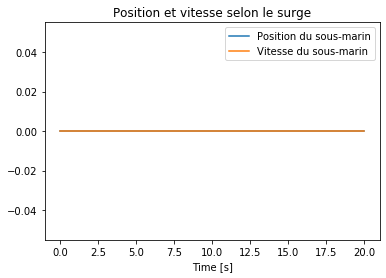

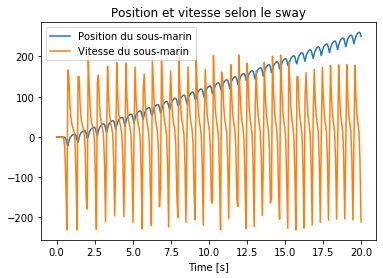

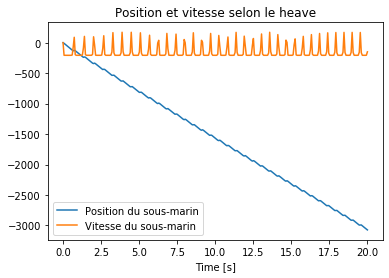

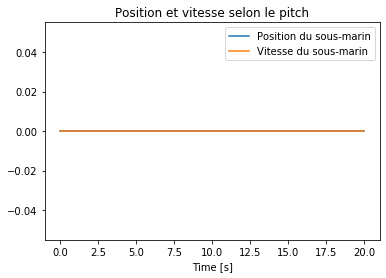

In [7]:
def plot(t,sol,axe = None ):
    if axe == 'surge' :
        position = sol[:,0] # Position selon le surge
        vitesse = sol[:,6] # Vitesse selon le surge
    elif axe == 'sway':
        position = sol[:,1] # Position selon le sway
        vitesse = sol[:,7] # Vitesse selon le sway
    elif axe == 'heave':
        position = sol[:,2] # Position selon le heave
        vitesse = sol[:,8] # Vitesse selon le heave
    elif axe == 'roll':
        position = sol[:,3] # Position selon le roll
        vitesse = sol[:,9] # Vitesse selon le roll
    elif axe == 'pitch':
        position = sol[:,4] # Position selon le pitch
        vitesse = sol[:,10] # Vitesse selon le pitch
    elif axe == 'yaw' :
        position = sol[:,5] # Position selon le yaw
        vitesse = sol[:,11] # Vitesse selon le yaw
    else : 
        print ('SVP choisir un axe à afficher')
        
    plt.plot(t, position, label='Position du sous-marin')
    plt.plot(t, vitesse, label='Vitesse du sous-marin')
    plt.title('Position et vitesse selon le '+ axe)
    plt.xlabel('Time [s]')
    plt.legend()
    plt.show()

plot(t,sol,axe = 'surge')
plot(t,sol,axe = 'sway')
plot(t,sol,axe = 'heave')
plot(t,sol,axe = 'roll')
plot(t,sol,axe = 'pitch')
plot(t,sol,axe = 'yaw')
